# El problema de la sucesión de Fibonacci

## Pequeño contexto:
La serie de Fibonacci esta definida como:
$$
F(n) = \left\{ \begin{array}{cl}
F(0)=1 \\
F(1)=1 \\
F(n) = F(n-1)+F(n-2) & : \ n \ge 2
\end{array} \right.
$$

La secuencia es de la forma $0,1,1,2,3,5,8,13,21,\dots$

En la Enciclopedia Online de las Secuencias de números Enteros (OEIS) se lo
encuentra con el identificativo [A000045](https://oeis.org/A000045)

Vamos a proponer variantes tanto las que se usan de forma intuitiva, como
aquellas un tanto extremas y raras para lograr conseguir el $n$-estimo término
 de la serie

In [16]:
import tracemalloc
import time
from functools import wraps
from typing import List

import numpy as np


VERBOSE = False # verdadero para hacer printable resultados, falso para retornar los valores como diccionario (util para graficar)


# Decorador medidor de tiempo
def measure_time(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)  # TODO: agregar un Timeout controlado por Threads, asi se puede definir hasta cuantos minutos puede tomar esa prueba como maximo, si supera el tiempo, arroje una excepción
        end_time = time.time()
        elapsed_time = end_time - start_time
        if VERBOSE:
            print(f"Tiempo de ejecucion: {elapsed_time} seg")
            return result
        if isinstance(result, tuple) and len(result) == 2 and isinstance(result[1], dict):
            result[1]["time"] = elapsed_time
            return result
        else:
            return result, {"time": elapsed_time}
    return wrapper

# Decorador medidor de Memoria
def measure_memory(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        tracemalloc.start()
        result = func(*args, **kwargs)
        _, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        if VERBOSE:
            print(f"Memoria usada aproximada: {peak/(1<<(10*2))} MB")
            return result
        if isinstance(result, tuple) and len(result) == 2 and isinstance(result[1], dict):
            result[1]["memory"] = peak
            return result
        else:
            return result, {"memory": peak}
    return wrapper

## Variante 1, Uso de Recursividad y la técnica del Divide y Vencerás <!-- Debería dejar de nombrar a las variantes como "Variantes" XD -->
Este es el algoritmo que se ensena por exelencia, es facil, corto e intuitivo.

In [17]:
VERBOSE = True # para hacer _printable_ el resultado
def _fibonacci_recursive(n: int) -> int:
    if n <= 1:
        return n
    return _fibonacci_recursive(n-1) + _fibonacci_recursive(n-2)

@measure_time
@measure_memory
def fibonacci_recursive(n: int) -> int:
    return _fibonacci_recursive(n)
# print(fibonacci_recursive(50))

Sin embargo, esconde a primera vista un problema, hay operaciones que se
repiten en cada llamada a recursion.

Si no se controla las llamadas repetidas, la eficiencia se _"resiente"_. Lo
cual hace que su complejidad temporal sea exponencial $O(2^n)$. Nada óptimo.

Si consideramos la complejidad espacial, cada llamada recursiva es un espacio
 que se consume en la pila. Aquí un paréntesis, aunque algo contra intuitivo a
  primera vista, esta recursion lo que hace realmente es una búsqueda en
  profundidad, es decir, para cada recursion se llamara o se ejecutara
  siempre la primera llamada al método, esto hasta llegar al caso base de la
  recursion. Teóricamente por cada rama visitada (y _decolada_ de la pila) al
  agregar la otra rama para visitarla igualmente a profundidad, no incrementa
   la memoria, sino que hasta cierto punto lo reutiliza, por lo que la
   complejidad espacial en este caso es $O(N)$

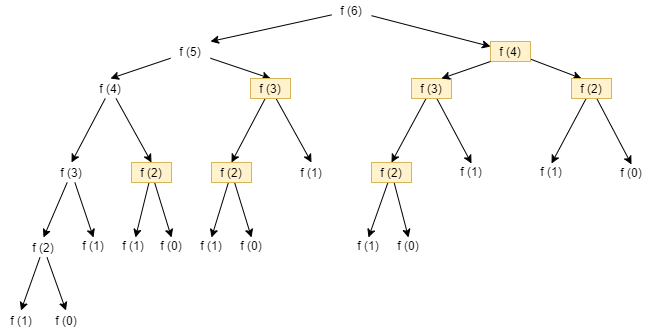 source: https://textbooks.cs.ksu.edu/cc210/16-recursion/06-example-fibonacci/

Para evitar que en cada recursion caiga en casos repetidos, se debe aplicar
una técnica llamada `Memoization`. Esta técnica ayudará evitar dichos casos
repetidos al almacenar en una lista los casos ya visitados, y posteriormente
poderlos reusar.

## Variante 2, Uso de Recursividad y Memoization
La técnica de Memoization permitirá omitir o "podar" los casos repetidos.
Esto es una ganancia a nivel temporal, puesto que ahora únicamente recorrerá
teóricamente en los casos faltantes, y eso implica una complejidad lineal $O(N)$

En memoria, esta variante también es de complejidad $O(N)$

In [18]:
memo_dict = {}
def _fibonacci_recursive_with_memo_using_dictionary(n: int) -> int:
    if n <= 1:
        return n
    if n in memo_dict: # búsqueda lineal teórica si no existe colisión
        return memo_dict[n]
    memo_dict[n] = _fibonacci_recursive_with_memo_using_dictionary(n - 1) + _fibonacci_recursive_with_memo_using_dictionary(n - 2)
    return memo_dict[n]

@measure_time
@measure_memory
def fibonacci_recursive_with_memo_using_dictionary(n: int) -> int:
    return _fibonacci_recursive_with_memo_using_dictionary(n)

print("Primera llamada")
print(fibonacci_recursive_with_memo_using_dictionary(50))
print("Segunda llamada")
print(fibonacci_recursive_with_memo_using_dictionary(50))

Primera llamada
Memoria usada aproximada: 0.024211883544921875 MB
Tiempo de ejecucion: 0.00015664100646972656 seg
12586269025
Segunda llamada
Memoria usada aproximada: 0.0 MB
Tiempo de ejecucion: 1.1444091796875e-05 seg
12586269025


In [19]:
# O(n) time and O(n) space
def _fibonacci_recursive_with_local_memoization(n: int, memo: List[int]) -> int:
    if n <= 1:
        return n
    if memo[n] != -1:
        return memo[n]
    memo[n] = _fibonacci_recursive_with_local_memoization(n - 1, memo) + _fibonacci_recursive_with_local_memoization(n - 2, memo)
    return memo[n]

@measure_time
@measure_memory
def fibonacci_recursive_with_local_memoization(n: int) -> int:
    memo = [-1]*(n+1)  # Crea un Array lleno de -1 de tamaño (n+1)
    return _fibonacci_recursive_with_local_memoization(n, memo)

print("Primera llamada")
print(fibonacci_recursive_with_local_memoization(50))
print("Segunda llamada")
print(fibonacci_recursive_with_local_memoization(50))

Primera llamada
Memoria usada aproximada: 0.021636962890625 MB
Tiempo de ejecucion: 0.0001399517059326172 seg
12586269025
Segunda llamada
Memoria usada aproximada: 0.002227783203125 MB
Tiempo de ejecucion: 8.487701416015625e-05 seg
12586269025


Ambas propuestas (`fibonacci_recursive_with_memo_using_dictionary`, y
`fibonacci_recursive_with_local_memoization`) aplican la tecnica de
`Memoization`, pero cada una tiene cierta diferencia:

La propuesta `fibonacci_recursive_with_memo_using_dictionary`
usa un diccionario, y este diccionario es declarado como variable global
(cosa que no va acorde a Clean Code), esto permite reutilizar este
diccionario tantas veces sean necesarias, puede incrementar sin necesidad de
`preallocate` la estructura de datos que almacenara los visitados, y su
búsqueda amortizada es de complejidad constante

La propuesta `fibonacci_recursive_with_local_memoization` por otra parte,
cada vez que se invoca al método general (no al recursivo), creara una nueva
lista de tamaño $n+1$.

La diferencia es a nivel de reutilización, mientras que la propuesta con
diccionario se puede reusar para cualquier llamada, la propuesta con lista
requerirá construir nuevamente la lista de valores visitados.

## Variante 3, Fibonacci iterativo

#TODO: Explicar sobre esta variante

In [20]:
def _fibonacci_iterative(n: int) -> int:
    if n <= 1:
        return n
    grandparent = 0
    parent = 1
    current = 0
    for i in range(2, n+1):
        current = parent + grandparent
        grandparent = parent
        parent = current
    return current

@measure_time
@measure_memory
def fibonacci_iterative(n: int) -> int:
    return _fibonacci_iterative(n)

print(fibonacci_iterative(50))

Memoria usada aproximada: 0.000576019287109375 MB
Tiempo de ejecucion: 9.942054748535156e-05 seg
12586269025


# Variante 4. Exponencial Matricial

Este caso sin optimización es costoso computacionalmente, las operaciones
matriciales son costosas cuando requieren elevarse a números muy grandes

#TODO: Explicar este caso interesante,

refs:
* https://www.nayuki.io/page/fast-fibonacci-algorithms
* https://www.youtube.com/watch?v=KzT9I1d-LlQ
* https://github.com/SheafificationOfG/Fibsonicci/tree/main

In [21]:
@measure_time
@measure_memory
def fibonacci_matrix(n): # version más teórica, sin optimizaciones
    if n <= 1:
        return n
    mat1 = np.array([[1, 1], [1, 0]])
    mat1 = np.linalg.matrix_power(mat1, n - 1)
    return mat1[0][0].astype(int)

print(fibonacci_matrix(50))

Memoria usada aproximada: 0.00092315673828125 MB
Tiempo de ejecucion: 0.0002713203430175781 seg
12586269025


que paso en esta variante

pos esto...

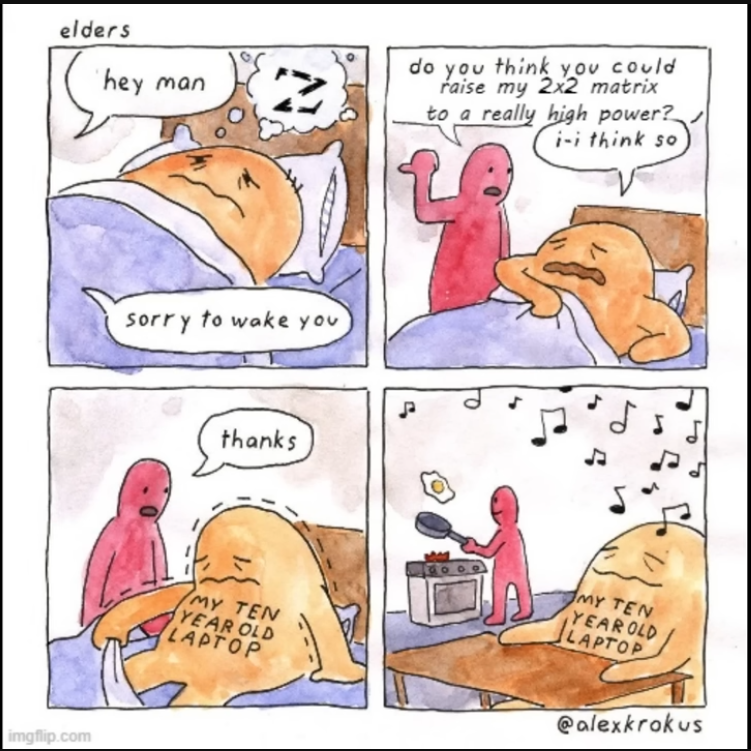

In [22]:
class Matrix2x2:
    def __init__(self, e00: int, e01: int, e10: int, e11: int):
        self.e00 = e00
        self.e01 = e01
        self.e10 = e10
        self.e11 = e11

    # Sobrecarga del operador * (equivalente a operator*)
    def __mul__(self, other: 'Matrix2x2') -> 'Matrix2x2':
        return Matrix2x2(
            e00=self.e00 * other.e00 + self.e01 * other.e10,
            e01=self.e00 * other.e01 + self.e01 * other.e11,
            e10=self.e10 * other.e00 + self.e11 * other.e10,
            e11=self.e10 * other.e01 + self.e11 * other.e11
        )

@measure_time
@measure_memory
def fibonacci_matrix_optimized(n: int) -> int:
    # M2x2 step(0, 1, 1, 1);
    # Representa la matriz de transición de Fibonacci:
    # [0 1]
    # [1 1]
    step = Matrix2x2(0, 1, 1, 1)

    # M2x2 fib(step);
    # Nota: El algoritmo original inicializa el acumulador con 'step' (M^1).
    # Esto resulta en que al final del ciclo se calcula M^(n+1).
    fib = step

    count = n  # Usamos una copia para no modificar el argumento (buena práctica en Python)

    while count > 0:
        if (count & 1) != 0:
            # fib *= step
            fib *= step

        # step *= step
        step *= step

        # n >>= 1
        count >>= 1

    return fib.e00

print(fibonacci_matrix_optimized(50))

Memoria usada aproximada: 0.00151824951171875 MB
Tiempo de ejecucion: 0.00012731552124023438 seg
12586269025
